In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. Motivate

1. val,test를 보면 제목만 주어지고 song나 tags에 대한 정보가 전혀 없는 경우가 있다.
2. 때문에 플레이리스트 제목을 활용해볼 것이다.
3. 제목은 매우 유용한 정보이다.
4. Tags와 플레이리스트를같이 보다보면 제목에 있는 단어를 그대로 붙이는 경우가 많다.

In [4]:
import json
import pandas as pd

with open("/content/gdrive/My Drive/project_data/train.json",'r',encoding='utf-8',errors='ignore') as F:
    data = json.load(F)
    train = pd.DataFrame(data)
    
with open("/content/gdrive/My Drive/project_data/val.json",'r',encoding='utf-8',errors='ignore') as F:
    data = json.load(F)
    val = pd.DataFrame(data)    

In [6]:
print(train.shape)
print(val.shape)

(115071, 6)
(23015, 6)


## 1) val을 보면 제목만 주어지고 song나 tags에 대한 정보가 전혀 없는 경우가 있다.

In [5]:
val[(val['tags']+val['songs']).map(len) == 0]

,tags,id,plylst_title,songs,like_cnt,updt_date
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000
9,[],142007,기분 좋은 재즈와 함께 만드는 달달한 하루,[],0,2015-06-22 09:11:02.000
35,[],65114,"■■■■ 사랑,그리고이별 ■■■■",[],6,2010-10-27 10:34:34.000
57,[],87700,마쉬멜로우같은 멜로우한 음악,[],6,2016-01-14 10:19:30.000
71,[],35271,공부와 독서를 위한 #Newage,[],10,2020-01-17 15:46:20.000
...,...,...,...,...,...,...
22903,[],140513,10년이 지나 들어도 좋은 감성 Ballad,[],405,2016-01-11 10:58:05.000
22920,[],124704,가사의 의미와 뜻은모른다!! 오직 멜로디로만 선곡한 팝송!!,[],27,2016-02-05 12:31:59.000
22981,[],13045,＊카페 느낌 샹송♭,[],38,2011-07-12 00:58:39.000
22991,[],32537,컨트리 황제 조니 캐시가 선 레코드 시절 발표한 초기 대표작,[],28,2019-06-17 14:22:48.000


## 4) Tags와 플레이리스트를 같이 보면 제목 단어를 그대로 태그에 붙이는 경우가 있다.

In [7]:
train.tail()

,tags,id,plylst_title,songs,like_cnt,updt_date
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000
115070,"[노래추천, 팝송추천, 팝송, 팝송모음]",100389,FAVORITE POPSONG!!!,"[26008, 456354, 324105, 89871, 135272, 143548,...",17,2020-04-18 20:35:06.000


In [8]:
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

Cloning into 'khaiii'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 1000 (delta 38), reused 61 (delta 22), pack-reused 877
Receiving objects: 100% (1000/1000), 33.06 MiB | 26.85 MiB/s, done.
Resolving deltas: 100% (396/396), done.
-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- w

# 2. 정답 Tags에서 자주 사용되는 품사 확인

- 정답에서 형태소 분석을 해 단어를 추출한다.
- 그러나 모든 형태소가 추측에 도움이 되지 않는다.
- 조사나 접속사 같은 불용어나 특수 기호를 제거하자.
- 어떤 품사가 태그 예측에 도움이 되는지 확인하기 위해 Tag의 품사를 확인한다.

In [10]:
import json
import re
from collections import Counter
from typing import *

import matplotlib.pyplot as plt
import numpy as np
from khaiii import KhaiiiApi

In [13]:
def re_sub(series: pd.Series) -> pd.Series:
    series = series.str.replace(pat=r'[ㄱ-ㅎ]', repl=r'', regex=True)  # ㅋ 제거용
    series = series.str.replace(pat=r'[^\w\s]', repl=r'', regex=True)  # 특수문자 제거
    series = series.str.replace(pat=r'[ ]{2,}', repl=r' ', regex=True)  # 공백 제거
    series = series.str.replace(pat=r'[\u3000]+', repl=r'', regex=True)  # u3000 제거
    return series

def flatten(list_of_list : List) -> List:
    flatten = [j for i in list_of_list for j in i]
    return flatten

def get_token(title: str, tokenizer) -> List[Tuple]:

  if len(title) == 0 or title == " " :
    return []

  result = tokenizer.analyze(title)
  result = [(morph.lex, morph.tag) for split in result for morph in split.morphs]
  return result


def get_all_tags(df) -> List :
  tag_list = df['tags'].values.tolist()
  tag_list = flatten(tag_list)
  return tag_list

In [15]:
tokenizer = KhaiiiApi()
all_tag = get_all_tags(train)
token_tag = [get_token(x, tokenizer) for x in all_tag]

In [16]:
token_tag[:10]

[[('락', 'MAG')],
 [('추억', 'NNG')],
 [('회상', 'NNG')],
 [('까페', 'NNG')],
 [('잔잔', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')],
 [('연말', 'NNG')],
 [('눈', 'NNG'), ('오', 'VV'), ('는', 'ETM'), ('날', 'NNG')],
 [('캐럴', 'NNG')],
 [('분위기', 'NNG')],
 [('따듯', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')]]

In [17]:
train.head(5)

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000


In [20]:
token_itself = list(filter(lambda x : len(x) == 1 , token_tag))
token_itself = flatten(token_itself)
flatten_token = flatten(token_tag)

In [21]:
print('%-23s'%'# of original tag is', f'{len(all_tag):8,}')
print('%-23s'%'# of morpheme itself is', f'{len(token_itself):8,}')
print('%-23s'%'# of total token is', f'{len(flatten_token):8,}')

# of original tag is     476,331
# of morpheme itself is  333,093
# of total token is      722,860


In [37]:
# 품사 세기 (pos)
pos = [x[0] for x in token_itself]
pos_count = Counter(pos)
popular_pos = pos_count.most_common(4) # 빈도수 높은 상위순으로 뽑아내기

In [29]:
popular_pos

[('감성', 11417), ('휴식', 11215), ('발라드', 10796), ('드라이브', 10095)]

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44048 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55092 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46972 missing from current font.
  font.set_

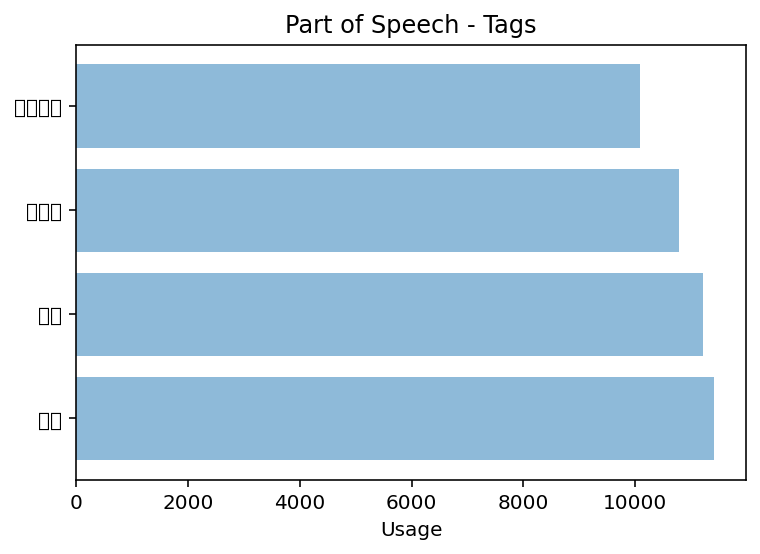

In [39]:
objects = [x[0] for x in popular_pos]
y_pos = np.arange(len(objects))
performance = [x[1] for x in popular_pos]

plt.barh(y_pos, performance, align = 'center', alpha = 0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Part of Speech - Tags')

plt.show()

# 3. 플레이리스트 제목을 형태소 분석

- NNG, SL, NNP, MAG, SN이 압도적으로 많다.
- 각각 일반 명사, 외국어, 고유 명사, 일반 부사, 숫자이다.
- 확인해 보면 숫자의 경우 7080, 2000 같은 태그가 있다.
- 제목을 형태소 분석한 결과가 위의 품사인 경우만 남기자.

In [44]:
train['plylst_title'].fillna('', inplace=True)
val['plylst_title'].fillna('', inplace=True)

train['plylst_title'] = re_sub(train['plylst_title'])
train.loc[:, 'ply_token'] = train['plylst_title'].map(lambda x: get_token(x, tokenizer))
train['comb_tags'] = re_sub(train['comb_tags'])
train.loc[:, 'tag_token'] = train['comb_tags'].map(lambda x: get_token(x, tokenizer))

val['plylst_title'] = re_sub(val['plylst_title'])
val.loc[:, 'ply_token'] = val['plylst_title'].map(lambda x: get_token(x, tokenizer))
val['comb_tags'] = re_sub(val['comb_tags'])
val.loc[:, 'tag_token'] = val['comb_tags'].map(lambda x: get_token(x, tokenizer))

KeyError: ignored

In [ ]:
using_pos = ['NNG','SL','NNP','MAG','SN']
train['ply_token'] = train['ply_token'].map(lambda x: list(filter(lambda x: x[1] in using_pos, x)))
train['tag_token'] = train['tag_token'].map(lambda x: list(filter(lambda x: x[1] in using_pos, x)))

val['ply_token'] = val['ply_token'].map(lambda x: list(filter(lambda x: x[1] in using_pos, x)))
val['tag_token'] = val['tag_token'].map(lambda x: list(filter(lambda x: x[1] in using_pos, x)))

In [42]:
train['title_token'] = train['ply_token'].map(lambda x: [tag[0] for tag in x])
train['tags_token'] = train['tag_token'].map(lambda x: [tag[0] for tag in x])

val['title_token'] = val['ply_token'].map(lambda x: [tag[0] for tag in x])
val['tags_token'] = val['tag_token'].map(lambda x: [tag[0] for tag in x])

In [43]:
train.drop(['ply_token', 'tag_token', 'comb_tags'], axis=1, inplace=True)
val.drop(['ply_token', 'tag_token', 'comb_tags'], axis=1, inplace=True)

,tags,id,plylst_title,songs,like_cnt,updt_date,ply_token
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"[(여행, NNG), (음악, NNG)]"
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"[(요즘, NNG), (말, NNG)]"
2,"[까페, 잔잔한]",76951,편하게 잔잔하게 들을 수 있는 곡,"[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"[(곡, NNG)]"
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"[(크리스마스, NNG), (분위기, NNG), (흠뻑, MAG)]"
4,[댄스],27616,추억의 노래,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"[(추억, NNG), (노래, NNG)]"
5,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...",69252,2017 Pop Trend,"[418694, 222305, 96545, 135950, 304687, 457451...",435,2017-09-15 15:59:26.000,"[(2017, SN), (Pop, SL)]"
6,"[짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]",45339,짝사랑고백사랑이별슬픔 감성을 자극하는곡들,"[528130, 505036, 398947, 627363, 37748, 376358...",24,2016-10-24 21:30:17.000,"[(짝사랑, NNG), (감성, NNG), (자극, NNG), (곡, NNG)]"
7,"[잔잔한, 추억, 회상]",36557,멍청이 내맘도 몰라,"[496913, 632529, 501426, 515574, 411161, 10341...",5,2008-09-23 22:32:02.000,"[(맘, NNG)]"
8,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]",70741,DANCING IN THE MOONLIGHT 01,"[634861, 270738, 163936, 692209, 449477, 56342...",0,2019-11-30 21:17:59.000,"[(01, SN)]"
9,"[록, Metal, 이일우, M에센셜, 메탈, Rock, 락]",10288,록메탈 Written by 이일우,"[613315, 439294, 230806, 497932, 113479, 93506...",7,2016-06-17 18:23:54.000,"[(록메탈, NNP), (이일우, NNP)]"


In [46]:
train.to_json('/content/gdrive/My Drive/project_data/train_with_tt_token.json', orient='table')
val.to_json('/content/gdrive/My Drive/project_data/val_with_tt_token.json', orient='table')